# BA optimization

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


파이썬 코드를 실행하기 전에 항상 모든 모듈을 reload 하도록 강제 설정

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import selfies as sf
import torch
import time
from tqdm import tqdm, trange
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [4]:
## Inter-op parallelism
torch.set_num_interop_threads(4)
torch.get_num_interop_threads()
## Intra-op parallelism
torch.set_num_threads(4)
torch.get_num_threads()

4

In [5]:
class GPUCONFIGS:
    def __init__(self):
        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device('cuda:0' if self.use_cuda else 'cpu')
        if self.use_cuda: torch.cuda.set_device(self.device)
        
gpuconfigs = GPUCONFIGS()
print(torch.cuda.current_device())

0


In [6]:
REBADD_LIB_PATH = os.path.abspath(os.pardir)
if REBADD_LIB_PATH not in sys.path:
    sys.path = [REBADD_LIB_PATH] + sys.path

from rebadd.stackVAE import StackAugmentedVAE
from rebadd.datautils import GeneratorData
from rebadd.reinforce import REINFORCE_SCST_OFFPOLICY as REINFORCE

# 1. Generator

## 1-1) Data loading for generators

In [7]:
class DATACONFIGS:
    def __init__(self):
        ## input
        self.input_dir = os.path.join('processed_data', 'gsk3_jnk3_qed_sa')
        self.train_data_path = os.path.join(self.input_dir, 'fragments_list.pkl')
        self.vocab_data_path = os.path.join(self.input_dir, 'vocabulary.csv')
        ## output
        self.output_dir = os.path.join('outputs_2_optimize_ReBADD', 'gsk3_jnk3_qed_sa')
        assert os.path.exists(self.output_dir)

dataconfigs = DATACONFIGS()

In [8]:
gen_data = GeneratorData(pickle_data_path=dataconfigs.train_data_path,
                         vocabulary_path=dataconfigs.vocab_data_path,
                         use_cuda=gpuconfigs.use_cuda)

print(f"Number of training samples: {len(gen_data.data)}")
print(f"Number of vocabulary: {len(gen_data.vocabs)}")
print(f"Maximum of seqlen: {gen_data.max_seqlen}")

Number of training samples: 781797
Number of vocabulary: 53687
Maximum of seqlen: 40


## 1-2) Pretrained generators

In [9]:
kwargs_generator = {"input_size"         : gen_data.n_characters,
                    "output_size"        : gen_data.n_characters,
                    "max_seqlen"         : 40,
                    "hidden_size"        : 256,
                    "latent_size"        : 64,
                    "n_layers"           : 4,
                    "has_stack"          : True,
                    "stack_width"        : 256,
                    "stack_depth"        : 20,
                    "lr"                 : 1e-4,
                    "use_cuda"           : gpuconfigs.use_cuda,
                    "device"             : gpuconfigs.device,
                    "optimizer_instance" : torch.optim.RMSprop}

In [10]:
my_generator_after  = StackAugmentedVAE(**kwargs_generator)

In [11]:
class CKPTCONFIGS:
    def __init__(self):
        self.model_path = os.path.join('outputs_1_pretraining_ReBADD', 'gsk3_jnk3_qed_sa', 'checkpoint.pth')
        
ckptconfigs = CKPTCONFIGS()

In [12]:
my_generator_after.load_model(ckptconfigs.model_path)

# 2. Reinforcement learning

In [13]:
from ReBADD_config import Reward_gsk3_jnk3_qed_sa as Reward

## 2-1) RL design

In [14]:
my_reward_ft = Reward()

[DEBUG] GSK3(8515) = 0.740 (GT:0.740)
[DEBUG] JNK#(8515) = 0.670 (GT:0.670)
[DEBUG] QED(8515) = 0.495 (GT:0.495)
[DEBUG] SA(8515) = 2.127 (GT:2.127)


In [15]:
ReBADD = REINFORCE(data=gen_data, generator=my_generator_after, reward_ft=my_reward_ft, zeta=0.9999)

## 2-2) Training

In [16]:
model_path = os.path.join(dataconfigs.output_dir, 'checkpoint.pth')
losses_path = os.path.join(dataconfigs.output_dir, 'losses.csv')
plot_path = os.path.join(dataconfigs.output_dir, "plots_reward_losses.pdf")

In [17]:
def SMILES_generate(generator, n_to_generate, gen_data):
    generated = []
    for i in trange(n_to_generate):
        z = generator.sample_latent_vectors()
        sel = generator.evaluate(gen_data, z=z)
        sel = sel.replace(gen_data.start_token, "").replace(gen_data.end_token, "")
        smi = sf.decoder(sel)
        generated.append(smi)
    return generated

In [18]:
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

In [19]:
def show_reward_loss(rewards, losses, figsize=(8,2.5), filepath=None):
    fig, ax = plt.subplots(1,2,figsize=figsize)
    
    ax[0].plot(rewards)
    ax[0].set_xlabel('Training iteration')
    ax[0].set_ylabel('Average reward')
    ax[1].plot(rl_losses, 'r')
    ax[1].set_xlabel('Training iteration')
    ax[1].set_ylabel('Loss')
    
    plt.tight_layout()
    if filepath is None:
        plt.show()
    else:
        plt.savefig(filepath)

In [20]:
def write_history(tr_rewards, rl_losses, reconst_losses, entropy_losses,
                  gsk_list, jnk_list, qed_list, sa_list,
                  execution_times, filepath):
    
    df_history = pd.DataFrame({"REWARD":tr_rewards,
                               "LOSS":rl_losses,
                               "LOSS_RECONST":reconst_losses,
                               "LOSS_ENTROPY":entropy_losses,
                               "GSK3":gsk_list,
                               "JNK3":jnk_list,
                               "QED":qed_list,
                               "SA":sa_list,
                               "EXEC_TIME":execution_times})
    
    df_history.to_csv(filepath, index=False)
    return df_history

In [21]:
# Setting up some parameters for the experiment
n_iterations = 1000
checkpoint_stepsize = 50
behavior_stepsize = 20

[0001] rl_loss: 0.820	reconst_loss: 0.737	entropy_loss: 0.083	reward: 0.387	tau: 0.301	(37.447 sec)
[0002] rl_loss: 0.932	reconst_loss: 0.853	entropy_loss: 0.079	reward: 0.365	tau: 0.302	(86.795 sec)
[0003] rl_loss: 0.855	reconst_loss: 0.769	entropy_loss: 0.087	reward: 0.422	tau: 0.303	(150.247 sec)
[0004] rl_loss: 1.069	reconst_loss: 0.987	entropy_loss: 0.082	reward: 0.448	tau: 0.304	(211.695 sec)
[0005] rl_loss: 0.960	reconst_loss: 0.873	entropy_loss: 0.087	reward: 0.498	tau: 0.306	(277.237 sec)
[0006] rl_loss: 1.083	reconst_loss: 0.993	entropy_loss: 0.090	reward: 0.547	tau: 0.309	(340.847 sec)
[0007] rl_loss: 0.929	reconst_loss: 0.838	entropy_loss: 0.090	reward: 0.494	tau: 0.310	(403.999 sec)
[0008] rl_loss: 1.374	reconst_loss: 1.284	entropy_loss: 0.090	reward: 0.555	tau: 0.313	(466.260 sec)
[0009] rl_loss: 1.255	reconst_loss: 1.165	entropy_loss: 0.090	reward: 0.500	tau: 0.315	(527.810 sec)
[0010] rl_loss: 1.216	reconst_loss: 1.126	entropy_loss: 0.090	reward: 0.466	tau: 0.316	(591.8

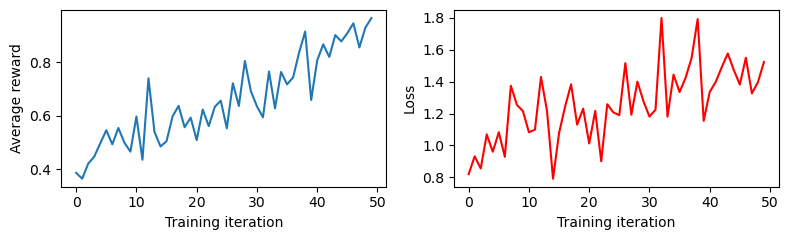

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.23it/s]


Sample trajectories: 100
[0.010, 0.010, 0.235, 3.409]    N(O)C=O
[0.330, 0.160, 0.504, 3.423]    CC(=O)NCC1CN(C(=O)O1)C2=CC=C(C(F)=C2)C3=CN=C(C(F)(F)F)N=C3NC4=CC=NC=N4
[0.000, 0.000, 0.379, 3.046]    NCC#N
[0.120, 0.080, 0.096, 5.247]    C1=CC=C(C=C1)NNCCCC2=CC=C3C=C2OC(=O)C3=CCC4NC(=O)C5NCC(C=C54)CNCC6=CC=CC=C6Cl
[0.060, 0.040, 0.259, 4.861]    NC=NC(N)=C(N=O)C(=N)C=CNC1COC2=CC(Cl)=C(Cl)N=C12
[0.080, 0.150, 0.208, 3.053]    COC1=CC=C(C=C1)C=CC=CC=NC=CCC2=CC(OC)=C(OC)C=C2C3=CC=CC(=C3)C(F)(F)F
[0.020, 0.010, 0.430, 4.224]    C1=CC2=CC3=C(C=C2)C=C31
[0.360, 0.020, 0.733, 1.848]    COC1=CC=C(C=C1OC)C2=CC=CC(=N2)C3=CC=NC=C3
[0.040, 0.000, 0.832, 5.157]    COC1=CC=C(C=C1)CCOC23C4CCCC2C(=C4N)CCN3C(=O)CF
[0.080, 0.050, 0.599, 3.066]    NCC1=CC=NC(O1)=CC2=CC=C(C=C2)CCCNS(=O)(=O)CC3=CC=CC(F)=C3
[0.030, 0.000, 0.720, 2.878]    CN1C=C(C2=CC=CC=C21)COC=CCF
[0.060, 0.000, 0.794, 2.846]    CC1=CC(=NN1C)CCCC(C)CC2=CC=CN=C2
[0.080, 0.000, 0.908, 2.946]    C1=CC=C(N=C1)C2CNCCC2CC3=CC=CC=C3
[0.050, 0.04

[0057] rl_loss: 1.341	reconst_loss: 1.169	entropy_loss: 0.172	reward: 1.035	tau: 0.487	(3651.879 sec)
[0058] rl_loss: 1.452	reconst_loss: 1.281	entropy_loss: 0.172	reward: 1.056	tau: 0.493	(3720.345 sec)
[0059] rl_loss: 1.911	reconst_loss: 1.737	entropy_loss: 0.174	reward: 1.173	tau: 0.499	(3790.328 sec)
[0060] rl_loss: 1.717	reconst_loss: 1.540	entropy_loss: 0.176	reward: 1.163	tau: 0.506	(3860.296 sec)
[0061] rl_loss: 1.546	reconst_loss: 1.369	entropy_loss: 0.177	reward: 1.182	tau: 0.513	(3931.039 sec)
[0062] rl_loss: 1.502	reconst_loss: 1.320	entropy_loss: 0.182	reward: 1.205	tau: 0.520	(4001.828 sec)
[0063] rl_loss: 1.370	reconst_loss: 1.188	entropy_loss: 0.182	reward: 1.184	tau: 0.526	(4075.352 sec)
[0064] rl_loss: 1.347	reconst_loss: 1.160	entropy_loss: 0.187	reward: 1.167	tau: 0.533	(4122.281 sec)
[0065] rl_loss: 1.410	reconst_loss: 1.224	entropy_loss: 0.186	reward: 1.205	tau: 0.539	(4161.642 sec)
[0066] rl_loss: 1.411	reconst_loss: 1.222	entropy_loss: 0.189	reward: 1.242	tau: 0

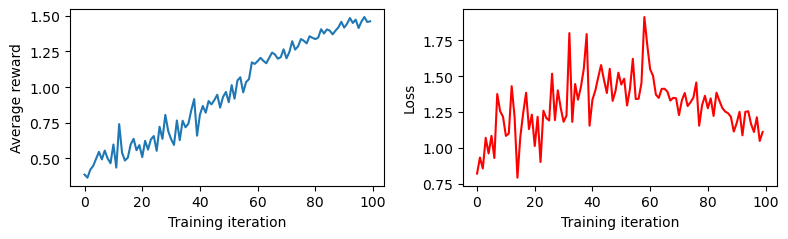

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.18it/s]


Sample trajectories: 100
[0.100, 0.040, 0.659, 4.070]    CC1=CC=CC(=N1)C=NC2=C(C(=O)NC=C23)CCCNC3C4=CC=C(Cl)C=C4
[0.770, 0.520, 0.793, 1.873]    COC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=CC=N3
[0.780, 0.780, 0.780, 2.206]    CC1=CC(=CC=N1)C2=CC=NC(=N2)NC3=CC=C(C=C3)N4CCOCC4
[0.800, 0.570, 0.795, 2.242]    CC1=CC(=CC=N1)C2=CC=NC(=N2)NC3=CC=C(C)N=C3
[0.590, 0.320, 0.773, 2.081]    C1=CC=C(N=C1)NC2=NC=CC(=N2)C3=CC=CC=N3
[0.700, 0.560, 0.274, 2.299]    COC1=CC=CC=C1C2=CC=CC(=C2)NS(=O)(=O)C3=CC=C(C=C3)NC4=NC=CC(=N4)C5=CC=NC=C5
[0.480, 0.080, 0.690, 2.324]    C1=CN=C2NC=C(C2=C1)CCC3=CC(Br)=CC(Br)=C3
[0.000, 0.010, 0.519, 2.786]    CC(N)C(=O)NC(C(O)=O)CNC(=O)CC(C1=CC=CC=C1)C2=CC=CC=C2
[0.100, 0.030, 0.820, 2.355]    C1NCCCN1C(=O)NC2=CC=CC3=CC=CN=C23
[0.800, 0.550, 0.312, 2.269]    COC1=CC(=CC(OC)=C1OC)NC2=NC=CC(=N2)C3=CC=CC(=C3)NC(=O)OCC4=CC=CC=C4
[0.000, 0.000, 0.451, 1.763]    O1C2=CC=CC=C21
[0.030, 0.000, 0.910, 2.372]    NC(=O)C1CCCCN1C(=O)C2=CC=C(C=C2)C(F)(F)F
[0.230, 0.590, 0.524, 2.269]    CC

[0107] rl_loss: 1.065	reconst_loss: 0.797	entropy_loss: 0.267	reward: 1.522	tau: 0.835	(5886.718 sec)
[0108] rl_loss: 1.162	reconst_loss: 0.893	entropy_loss: 0.269	reward: 1.560	tau: 0.842	(5929.247 sec)
[0109] rl_loss: 1.111	reconst_loss: 0.839	entropy_loss: 0.272	reward: 1.564	tau: 0.849	(5972.355 sec)
[0110] rl_loss: 1.170	reconst_loss: 0.898	entropy_loss: 0.272	reward: 1.528	tau: 0.856	(6014.019 sec)
[0111] rl_loss: 1.079	reconst_loss: 0.805	entropy_loss: 0.274	reward: 1.596	tau: 0.863	(6056.823 sec)
[0112] rl_loss: 1.140	reconst_loss: 0.864	entropy_loss: 0.277	reward: 1.575	tau: 0.871	(6099.430 sec)
[0113] rl_loss: 1.148	reconst_loss: 0.872	entropy_loss: 0.276	reward: 1.562	tau: 0.878	(6141.532 sec)
[0114] rl_loss: 1.073	reconst_loss: 0.793	entropy_loss: 0.280	reward: 1.615	tau: 0.885	(6185.277 sec)
[0115] rl_loss: 1.164	reconst_loss: 0.881	entropy_loss: 0.284	reward: 1.540	tau: 0.891	(6227.089 sec)
[0116] rl_loss: 1.182	reconst_loss: 0.897	entropy_loss: 0.285	reward: 1.589	tau: 0

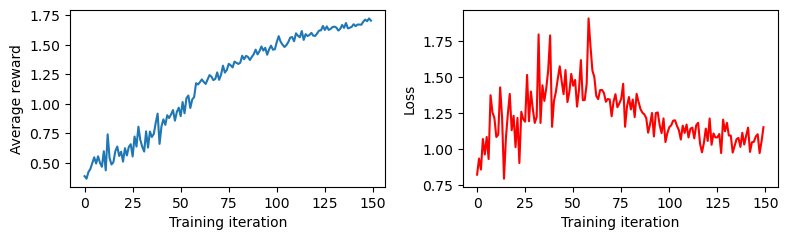

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 63.12it/s]


Sample trajectories: 100
[0.020, 0.000, 0.790, 2.519]    CC(=O)NC1=CC=C(C=C1)C2CNCCO2
[0.810, 0.470, 0.352, 2.442]    C1=CC=C(C=C1)NN=CC2=CSC=C2C3=CC=NC(=N3)NC4=CC=CC=C4
[0.280, 0.200, 0.784, 2.403]    C1=CC(=CC=N1)C2=NC=C(C=N2)C3=NC=CC(=N3)NC4CCCCC4
[0.830, 0.550, 0.627, 2.212]    COC1=CC(=CC(OC)=C1OC)NC2=NC=CC(=N2)C3=CC=CC(=C3)C(F)(F)F
[0.610, 0.300, 0.747, 3.437]    CN1C=NC=C(C=CC=N1)C2=CC=NC(=N2)NCC(C)C3=CC=C(F)C=C3
[0.770, 0.700, 0.785, 1.658]    COC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=CC=C3
[0.690, 0.520, 0.793, 1.921]    COC1=CC=CC=C1NC2=NC=CC(=N2)C3=CC=CN=C3
[0.650, 0.270, 0.689, 1.909]    CC1=CC=C(C=C1)NC2=NC=CC(=N2)NC3=CC=C(Br)C=C3
[0.840, 0.430, 0.648, 2.084]    COC(=O)CC1=CC=CC(=C1)NC2=NC=CC(=N2)C3=CC=CC(=C3)C(O)=O
[0.750, 0.630, 0.791, 1.997]    COC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=C4OCOC4=C3
[0.780, 0.780, 0.780, 2.206]    CC1=CC(=CC=N1)C2=CC=NC(=N2)NC3=CC=C(C=C3)N4CCOCC4
[0.780, 0.780, 0.780, 2.206]    CC1=CC(=CC=N1)C2=CC=NC(=N2)NC3=CC=C(C=C3)N4CCOCC4
[0.010, 0.000, 0.455, 3.44

[0156] rl_loss: 0.989	reconst_loss: 0.633	entropy_loss: 0.357	reward: 1.708	tau: 1.151	(8016.602 sec)
[0157] rl_loss: 1.029	reconst_loss: 0.670	entropy_loss: 0.359	reward: 1.733	tau: 1.156	(8062.013 sec)
[0158] rl_loss: 1.080	reconst_loss: 0.720	entropy_loss: 0.360	reward: 1.715	tau: 1.162	(8106.770 sec)
[0159] rl_loss: 0.976	reconst_loss: 0.614	entropy_loss: 0.363	reward: 1.736	tau: 1.168	(8150.565 sec)
[0160] rl_loss: 0.988	reconst_loss: 0.623	entropy_loss: 0.365	reward: 1.716	tau: 1.173	(8194.960 sec)
[0161] rl_loss: 0.981	reconst_loss: 0.615	entropy_loss: 0.365	reward: 1.743	tau: 1.179	(8239.237 sec)
[0162] rl_loss: 1.108	reconst_loss: 0.741	entropy_loss: 0.367	reward: 1.724	tau: 1.184	(8285.163 sec)
[0163] rl_loss: 1.019	reconst_loss: 0.649	entropy_loss: 0.370	reward: 1.739	tau: 1.190	(8330.809 sec)
[0164] rl_loss: 1.061	reconst_loss: 0.690	entropy_loss: 0.371	reward: 1.748	tau: 1.195	(8376.294 sec)
[0165] rl_loss: 1.077	reconst_loss: 0.703	entropy_loss: 0.374	reward: 1.761	tau: 1

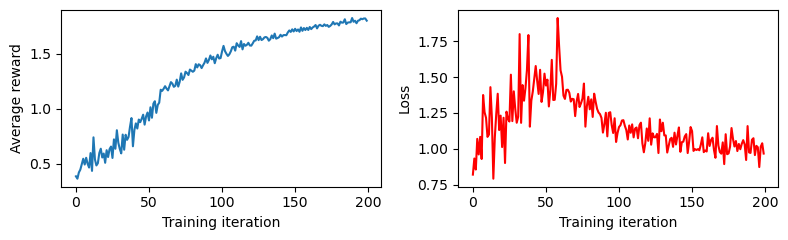

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.19it/s]


Sample trajectories: 100
[0.730, 0.700, 0.769, 1.815]    COC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=C(O)C=C3
[0.010, 0.000, 0.521, 2.997]    NC1=CC=CS1
[0.850, 0.760, 0.778, 1.916]    N#CC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=C(Cl)C=C3
[0.010, 0.000, 0.493, 2.116]    N#CC1=CC2=CC2=C1
[0.780, 0.680, 0.768, 2.235]    NC1=CC(=CC=N1)C2=CC=NC(=N2)NC3=CC=C(C#N)C=C3
[0.720, 0.670, 0.710, 2.001]    NC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=NC=C3
[0.780, 0.720, 0.574, 2.284]    C1=CC=C(C=C1)NC2=CC=C(C=N2)NC3=NC=CC(=N3)C4=CN(C)N=C4
[0.750, 0.590, 0.789, 1.917]    C1=CN=CC(=C1)NC2=NC=CC(=N2)C3=CC=C(F)C=C3
[0.870, 0.670, 0.757, 2.290]    CC1=CC(=CC=N1)C2=CC=NC(=N2)NC3=CC=C(C=C3)N4CCNCC4
[0.720, 0.670, 0.710, 2.001]    NC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=NC=C3
[0.100, 0.030, 0.916, 2.586]    NCC1CCN(C1)C2=CC=CN=C2CCC3=CC=CC=C3
[0.790, 0.560, 0.720, 2.078]    COC1=CC(=CC(OC)=C1OC)NC2=NC=CC(=N2)C3=CC=CC(F)=C3
[0.020, 0.010, 0.521, 3.496]    C1=CC=CC(=C1)NC=CC=CC(F)=CC2=CC=CC=CN=CC=C2C=N
[0.340, 0.240, 0.745, 3.264]    CC(=O

[0208] rl_loss: 0.966	reconst_loss: 0.516	entropy_loss: 0.450	reward: 1.843	tau: 1.408	(10349.304 sec)
[0209] rl_loss: 0.990	reconst_loss: 0.538	entropy_loss: 0.452	reward: 1.819	tau: 1.412	(10393.698 sec)
[0210] rl_loss: 0.962	reconst_loss: 0.507	entropy_loss: 0.455	reward: 1.825	tau: 1.416	(10438.800 sec)
[0211] rl_loss: 0.972	reconst_loss: 0.517	entropy_loss: 0.455	reward: 1.847	tau: 1.421	(10483.513 sec)
[0212] rl_loss: 0.995	reconst_loss: 0.538	entropy_loss: 0.456	reward: 1.820	tau: 1.425	(10529.107 sec)
[0213] rl_loss: 1.009	reconst_loss: 0.549	entropy_loss: 0.460	reward: 1.863	tau: 1.429	(10573.379 sec)
[0214] rl_loss: 1.109	reconst_loss: 0.649	entropy_loss: 0.460	reward: 1.841	tau: 1.433	(10617.589 sec)
[0215] rl_loss: 1.009	reconst_loss: 0.546	entropy_loss: 0.462	reward: 1.838	tau: 1.437	(10662.885 sec)
[0216] rl_loss: 0.964	reconst_loss: 0.499	entropy_loss: 0.465	reward: 1.858	tau: 1.441	(10707.361 sec)
[0217] rl_loss: 0.922	reconst_loss: 0.455	entropy_loss: 0.467	reward: 1.8

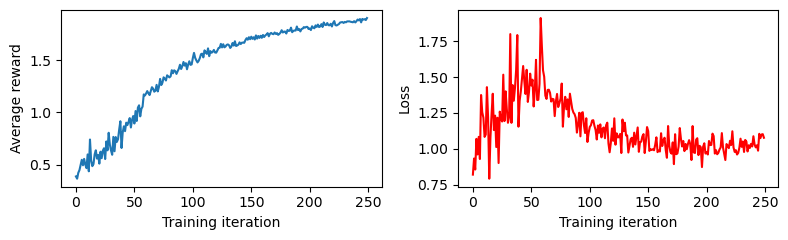

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 110.87it/s]


Sample trajectories: 100
[0.760, 0.630, 0.772, 1.825]    C1=CC=CC(=C1)NC2=NC=CC(=N2)C3=CC=NC=C3
[0.110, 0.010, 0.372, 5.023]    N#CC=CN=N
[0.830, 0.490, 0.763, 2.297]    CC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=C(C)C=NN3
[0.790, 0.630, 0.768, 1.795]    COC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=CC(Cl)=C3
[0.820, 0.490, 0.773, 2.143]    OC1=CC=CC(=C1)NC2=NC=CC(=N2)C3=CC=C4OCOC4=C3
[0.750, 0.630, 0.754, 2.107]    CNC(=O)C1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=C4OCOC4=C3
[0.880, 0.690, 0.777, 1.680]    C1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=C(F)C=C3
[0.710, 0.620, 0.746, 1.949]    COC(=O)C1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=NC=C3
[0.770, 0.690, 0.772, 1.820]    C1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=CN=C3
[0.750, 0.630, 0.791, 1.997]    COC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=C4OCOC4=C3
[0.760, 0.700, 0.758, 1.758]    C1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=C(O)C=C3
[0.820, 0.710, 0.768, 1.648]    CC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=CC=C3
[0.830, 0.610, 0.793, 1.950]    COC1=CC=C(C=N1)NC2=NC=CC(=N2)C3=CC=CC=C3
[0.930, 0.530, 0.785, 1.716]    

[0257] rl_loss: 1.055	reconst_loss: 0.518	entropy_loss: 0.537	reward: 1.912	tau: 1.588	(12550.476 sec)
[0258] rl_loss: 1.024	reconst_loss: 0.484	entropy_loss: 0.540	reward: 1.917	tau: 1.591	(12596.471 sec)
[0259] rl_loss: 1.004	reconst_loss: 0.463	entropy_loss: 0.541	reward: 1.900	tau: 1.594	(12640.600 sec)
[0260] rl_loss: 0.991	reconst_loss: 0.451	entropy_loss: 0.541	reward: 1.912	tau: 1.597	(12686.117 sec)
[0261] rl_loss: 1.071	reconst_loss: 0.527	entropy_loss: 0.544	reward: 1.930	tau: 1.601	(12730.636 sec)
[0262] rl_loss: 1.010	reconst_loss: 0.463	entropy_loss: 0.548	reward: 1.939	tau: 1.604	(12777.364 sec)
[0263] rl_loss: 1.064	reconst_loss: 0.517	entropy_loss: 0.547	reward: 1.940	tau: 1.607	(12822.828 sec)
[0264] rl_loss: 1.079	reconst_loss: 0.528	entropy_loss: 0.551	reward: 1.922	tau: 1.611	(12867.667 sec)
[0265] rl_loss: 1.028	reconst_loss: 0.476	entropy_loss: 0.552	reward: 1.933	tau: 1.614	(12911.489 sec)
[0266] rl_loss: 1.106	reconst_loss: 0.556	entropy_loss: 0.550	reward: 1.9

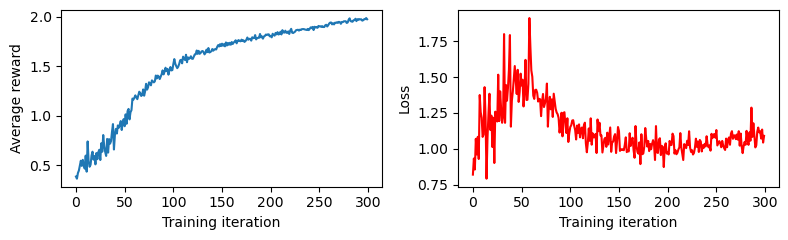

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.96it/s]


Sample trajectories: 100
[0.810, 0.630, 0.739, 1.954]    ClC1=CC=C(C=N1)NC2=NC=CC(=N2)C3=CC=CC=C3
[0.780, 0.740, 0.746, 2.212]    COC1=CC=C(C=N1)C2=CC=NC(=N2)NC3=CC=C(C=C3)N4CCOCC4
[0.780, 0.540, 0.783, 2.088]    CC1=CC=C(C=C1C)NC2=NC=CC(=N2)C3=CC=C4OCOC4=C3
[0.820, 0.580, 0.799, 2.026]    COC1=CC=C(C=N1)NC2=NC=CC(=N2)C3=CC=C(F)C=C3
[0.800, 0.590, 0.785, 2.011]    CC1=CC(=CC=N1)C2=CC=NC(=N2)NC3=CC=C(Cl)C=C3
[0.680, 0.490, 0.710, 2.061]    NC1=CC=CC(=C1)NC2=NC=CC(=N2)C3=CC=NC=C3
[0.770, 0.700, 0.799, 2.034]    CN(C)C1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=CN=C3
[0.760, 0.690, 0.506, 2.012]    COC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=C(N=C3)C4=CC=C(OC)C=C4
[0.750, 0.690, 0.555, 2.177]    CC1=CC=C(C=N1)C2=CC=NC(=N2)NC3=CC=C(C=C3)OC4=CC=CN=C4
[0.190, 0.200, 0.754, 2.156]    NC1=CC=CC=C1NC2=CC=C(C=N2)C(=O)NC3CCOCC3
[0.050, 0.020, 0.472, 3.893]    N=C(N)C1=C2C=CC(=C1)CC=C2
[0.020, 0.000, 0.552, 3.242]    CCCCCCC(C#N)CN1C=C(N=N1)CCC(=O)CCC
[0.850, 0.560, 0.684, 2.069]    COC1=CC(=CC(OC)=C1OC)NC2=NC=CC(=N2)

[0308] rl_loss: 1.112	reconst_loss: 0.485	entropy_loss: 0.627	reward: 1.992	tau: 1.737	(14819.453 sec)
[0309] rl_loss: 1.097	reconst_loss: 0.468	entropy_loss: 0.630	reward: 1.999	tau: 1.740	(14863.155 sec)
[0310] rl_loss: 1.079	reconst_loss: 0.449	entropy_loss: 0.630	reward: 1.993	tau: 1.742	(14907.630 sec)
[0311] rl_loss: 1.078	reconst_loss: 0.448	entropy_loss: 0.630	reward: 1.993	tau: 1.745	(14952.034 sec)
[0312] rl_loss: 1.083	reconst_loss: 0.449	entropy_loss: 0.634	reward: 1.998	tau: 1.747	(14994.810 sec)
[0313] rl_loss: 1.081	reconst_loss: 0.444	entropy_loss: 0.636	reward: 2.005	tau: 1.750	(15036.220 sec)
[0314] rl_loss: 1.010	reconst_loss: 0.373	entropy_loss: 0.637	reward: 1.988	tau: 1.752	(15079.632 sec)
[0315] rl_loss: 1.129	reconst_loss: 0.492	entropy_loss: 0.637	reward: 2.002	tau: 1.755	(15122.559 sec)
[0316] rl_loss: 1.073	reconst_loss: 0.432	entropy_loss: 0.640	reward: 1.996	tau: 1.757	(15166.890 sec)
[0317] rl_loss: 1.128	reconst_loss: 0.486	entropy_loss: 0.643	reward: 1.9

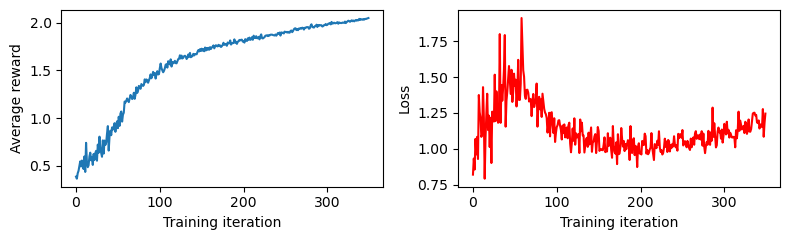

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.79it/s]


Sample trajectories: 100
[0.850, 0.630, 0.768, 2.299]    NCC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=C(C#N)N=C3
[0.880, 0.550, 0.768, 1.707]    CC1=CC=CC(=C1)NC2=NC=CC(=N2)C3=CC=CC=C3
[0.830, 0.500, 0.698, 2.137]    CCOC1=CC=CC(=C1)NC2=NC=CC(=N2)C3=CC=CC(=C3)N4CCOCC4
[0.850, 0.740, 0.793, 2.060]    CN(C)C1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=C(C#N)C=C3
[0.820, 0.650, 0.798, 2.014]    FC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=C4OCOC4=C3
[0.090, 0.040, 0.746, 2.731]    CC1=CC(=CC=N1)C2=CC=NC(=N2)N(C)C=O
[0.800, 0.670, 0.701, 2.287]    CCCC1=CC(=CC=N1)C2=CC=NC(=N2)NC3=CC=C(C=C3)N4CCOCC4
[0.170, 0.000, 0.514, 3.073]    C1C2=C(N)N=CN=C21
[0.760, 0.620, 0.691, 2.102]    C1=CC(=CC=N1)C2=CC=NC(=N2)NC3=CC=C(C=C3)OCCN4CCCC4
[0.840, 0.770, 0.788, 1.842]    N#CC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=CC=C3
[0.840, 0.700, 0.754, 2.021]    NCC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=C(N(C)C)C=C3
[0.060, 0.010, 0.836, 3.596]    C1=CC=CC(=C12)COC=CC=CC=CC=C(N2)N3CCNCC3
[0.800, 0.710, 0.643, 1.976]    NCC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=C(N)C

[0357] rl_loss: 1.175	reconst_loss: 0.466	entropy_loss: 0.708	reward: 2.059	tau: 1.849	(16954.130 sec)
[0358] rl_loss: 1.261	reconst_loss: 0.550	entropy_loss: 0.711	reward: 2.054	tau: 1.851	(16996.994 sec)
[0359] rl_loss: 1.207	reconst_loss: 0.492	entropy_loss: 0.715	reward: 2.053	tau: 1.853	(17037.508 sec)
[0360] rl_loss: 1.193	reconst_loss: 0.477	entropy_loss: 0.716	reward: 2.054	tau: 1.855	(17079.443 sec)
[0361] rl_loss: 1.193	reconst_loss: 0.477	entropy_loss: 0.716	reward: 2.056	tau: 1.857	(17121.564 sec)
[0362] rl_loss: 1.151	reconst_loss: 0.434	entropy_loss: 0.717	reward: 2.077	tau: 1.859	(17165.313 sec)
[0363] rl_loss: 1.169	reconst_loss: 0.447	entropy_loss: 0.721	reward: 2.070	tau: 1.861	(17209.175 sec)
[0364] rl_loss: 1.209	reconst_loss: 0.488	entropy_loss: 0.721	reward: 2.072	tau: 1.863	(17252.159 sec)
[0365] rl_loss: 1.239	reconst_loss: 0.515	entropy_loss: 0.724	reward: 2.071	tau: 1.865	(17295.365 sec)
[0366] rl_loss: 1.170	reconst_loss: 0.444	entropy_loss: 0.725	reward: 2.0

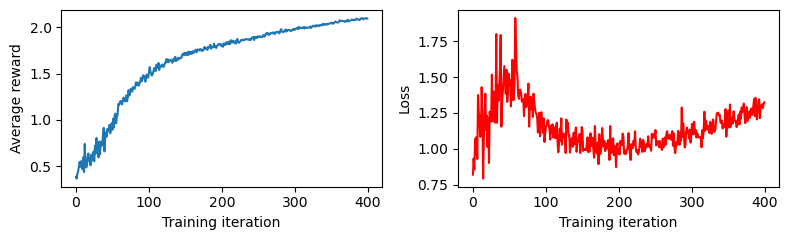

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.77it/s]


Sample trajectories: 100
[0.880, 0.690, 0.777, 1.680]    FC1=CC=C(C=C1)C2=CC=NC(=N2)NC3=CC=CC=C3
[0.810, 0.390, 0.434, 2.917]    C1C=C2C=C(SC2=C1)C3=CC=NC(=N3)NC4=CC=C(C(Cl)=C4)OCC5=CC=CC(F)=C5
[0.020, 0.050, 0.671, 5.629]    C1=CC=CC(=C12)C=NC3=CC4=CC5=C3C4SC25
[0.030, 0.000, 0.712, 1.952]    N#CC1=CC=C(C=C1)N2CCNCC2
[0.870, 0.730, 0.794, 1.921]    N#CC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=C(F)C=C3
[0.840, 0.460, 0.518, 2.522]    O=CC1=CC(Cl)=CC2=C1NC(=C2)C3=CC=NC(=N3)NC4=CC=CC=C4
[0.800, 0.750, 0.721, 2.017]    NC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=C(C#N)C=C3
[0.780, 0.650, 0.797, 2.166]    COC1=CC=C(C=N1)C2=CC=NC(=N2)NC3=CC=C(C#N)C=C3
[0.830, 0.570, 0.887, 2.356]    C1C=C1C2=CC=NC(=N2)NC3=CC=C(C#N)C=C3
[0.800, 0.820, 0.789, 1.927]    C1=CC=C(C=C1)C2=CC=NC(=N2)NC3=CC=C(C=C3)N4CCOCC4
[0.820, 0.610, 0.758, 1.821]    OC1=CC=CC(=C1)C2=CC=NC(=N2)NC3=CC=CC=C3
[0.850, 0.640, 0.766, 2.006]    COC1=CC=C(C=C1OC)NC2=NC=CC(=N2)C3=CC=C(C#N)C=C3
[0.810, 0.750, 0.667, 2.318]    NC1=CC=C(C=N1)C2=CC=NC(=N2)NC3

[0407] rl_loss: 1.347	reconst_loss: 0.559	entropy_loss: 0.789	reward: 2.114	tau: 1.942	(19087.957 sec)
[0408] rl_loss: 1.359	reconst_loss: 0.568	entropy_loss: 0.790	reward: 2.100	tau: 1.943	(19130.741 sec)
[0409] rl_loss: 1.363	reconst_loss: 0.568	entropy_loss: 0.794	reward: 2.101	tau: 1.945	(19173.182 sec)
[0410] rl_loss: 1.427	reconst_loss: 0.634	entropy_loss: 0.793	reward: 2.122	tau: 1.947	(19215.198 sec)
[0411] rl_loss: 1.447	reconst_loss: 0.652	entropy_loss: 0.794	reward: 2.111	tau: 1.948	(19257.266 sec)
[0412] rl_loss: 1.343	reconst_loss: 0.544	entropy_loss: 0.799	reward: 2.102	tau: 1.950	(19300.349 sec)
[0413] rl_loss: 1.363	reconst_loss: 0.565	entropy_loss: 0.798	reward: 2.109	tau: 1.952	(19343.699 sec)
[0414] rl_loss: 1.331	reconst_loss: 0.532	entropy_loss: 0.799	reward: 2.101	tau: 1.953	(19386.736 sec)
[0415] rl_loss: 1.440	reconst_loss: 0.639	entropy_loss: 0.801	reward: 2.110	tau: 1.955	(19428.726 sec)
[0416] rl_loss: 1.367	reconst_loss: 0.561	entropy_loss: 0.806	reward: 2.1

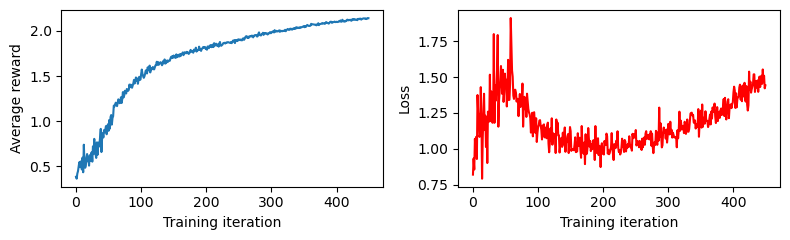

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.93it/s]


Sample trajectories: 100
[0.820, 0.710, 0.761, 1.737]    BrC1=CC=C(C=C1)C2=CC=NC(=N2)NC3=CC=CC=C3
[0.030, 0.000, 0.714, 1.946]    CC1=CC=CC=C1N2CCNC(=O)C2
[0.780, 0.670, 0.737, 1.965]    COC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=CC(=C3)N4CCCC4
[0.820, 0.690, 0.782, 1.938]    CN1CCN(CC1)C2=CC=C(C=C2)NC3=NC=CC(=N3)C4=CC=CC=C4
[0.130, 0.340, 0.877, 1.885]    CCOC1=CC=C(C=C1)NC2=NC=CC(F)=C2
[0.770, 0.690, 0.789, 1.892]    FC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=CN=C3
[0.850, 0.530, 0.356, 2.148]    ClC1=CC=C(C=C1)C2=C(C3=CC=CC=C3N2)C4=CC=NC(=N4)NC5=CC=CC=C5
[0.830, 0.740, 0.766, 1.664]    C1=CC=C(C=C1)C2=CC=NC(=N2)NC3=CC=C(Cl)C=C3
[0.820, 0.670, 0.759, 1.986]    NC1=CC=C(C=N1)C2=CC=NC(=N2)NC3=CC=CC=C3
[0.850, 0.680, 0.769, 2.267]    CNC1=CC(=CC=N1)C2=CC=NC(=N2)NC3=CC=C(C#N)C=C3
[0.790, 0.770, 0.791, 2.024]    C1=CC=C(C=N1)C2=CC=NC(=N2)NC3=CC=C(C=C3)N4CCCC4
[0.830, 0.650, 0.730, 2.396]    CN(CCC#N)C1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=C(C)N=C3
[0.820, 0.670, 0.759, 1.986]    NC1=CC=C(C=N1)C2=CC=NC(=N2)NC3=CC

[0455] rl_loss: 1.449	reconst_loss: 0.579	entropy_loss: 0.869	reward: 2.151	tau: 2.013	(21106.574 sec)
[0456] rl_loss: 1.445	reconst_loss: 0.579	entropy_loss: 0.865	reward: 2.143	tau: 2.014	(21148.664 sec)
[0457] rl_loss: 1.455	reconst_loss: 0.589	entropy_loss: 0.866	reward: 2.142	tau: 2.016	(21189.444 sec)
[0458] rl_loss: 1.469	reconst_loss: 0.597	entropy_loss: 0.872	reward: 2.147	tau: 2.017	(21228.877 sec)
[0459] rl_loss: 1.524	reconst_loss: 0.654	entropy_loss: 0.870	reward: 2.137	tau: 2.018	(21270.532 sec)
[0460] rl_loss: 1.552	reconst_loss: 0.679	entropy_loss: 0.873	reward: 2.150	tau: 2.019	(21312.363 sec)
[0461] rl_loss: 1.574	reconst_loss: 0.701	entropy_loss: 0.873	reward: 2.156	tau: 2.021	(21353.089 sec)
[0462] rl_loss: 1.443	reconst_loss: 0.567	entropy_loss: 0.876	reward: 2.163	tau: 2.022	(21395.717 sec)
[0463] rl_loss: 1.532	reconst_loss: 0.657	entropy_loss: 0.876	reward: 2.155	tau: 2.023	(21437.408 sec)
[0464] rl_loss: 1.452	reconst_loss: 0.571	entropy_loss: 0.881	reward: 2.1

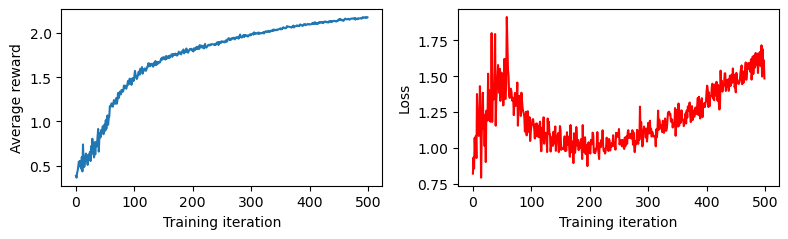

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.93it/s]


Sample trajectories: 100
[0.000, 0.000, 0.699, 1.728]    FC1=CC=C(C=C1)N2CCNCC2
[0.780, 0.800, 0.780, 2.170]    CC1=CC=C(C=N1)C2=CC=NC(=N2)NC3=CC=C(C=C3)N4CCOCC4
[0.880, 0.690, 0.777, 1.680]    FC1=CC=C(C=C1)C2=CC=NC(=N2)NC3=CC=CC=C3
[0.890, 0.680, 0.738, 2.017]    FC1=CC=C(C=N1)C2=CC=NC(=N2)NC3=CC=CC=C3
[0.870, 0.680, 0.793, 2.138]    N#CC1=CC=C(C=N1)C2=CC=NC(=N2)NC3=CC=CC=C3
[0.850, 0.670, 0.774, 1.785]    COC1=CC=C(C=C1OC)C2=CC=NC(=N2)NC3=CC=CC=C3
[0.080, 0.020, 0.363, 3.071]    N#CC=CC=C(OC1=CC=CN=C1)N=CC2=CC=CC=C2
[0.850, 0.760, 0.778, 1.916]    ClC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=C(C#N)C=C3
[0.050, 0.050, 0.722, 3.873]    FC1=CC=C(C=C1)C=C2C=NC3CCC=CN(C3=C2)C4=CC=C(F)N=C4
[0.870, 0.710, 0.766, 1.674]    ClC1=CC=C(C=C1)C2=CC=NC(=N2)NC3=CC=CC=C3
[0.870, 0.680, 0.793, 2.138]    N#CC1=CC=C(C=N1)C2=CC=NC(=N2)NC3=CC=CC=C3
[0.810, 0.660, 0.743, 2.217]    N#CC1=CC=C(C=C1)NC2=NC=CC(=N2)C3=CC=C(C=C3F)N4CCCC4
[0.110, 0.060, 0.915, 4.921]    C1=CC=CC(=C1)C2=CC=CC(=C2)C34CC5OCC3N=C5N4
[0.220, 

In [22]:
tr_rewards = [] # rewards when training the model
rl_losses = [] # loss when training the model
reconst_losses = [] # reconstruction loss
entropy_losses = [] # entropy regularization

gsk_list = []
jnk_list = []
qed_list = []
sa_list = []

execution_times = []

## Training RL optimizer
start_time = time.time()

alpha_min = 0.01
alpha_max = 0.1
alpha_inc = (alpha_max - alpha_min) / n_iterations
alpha = alpha_min
for i in range(1, n_iterations+1):
    ## policy gradient
    alpha += alpha_inc
    cur_reward, cur_loss, cur_reconst, cur_entropy = ReBADD.policy_gradient(grad_clipping=1., alpha=alpha)
    
    ## append - reward
    #reward = simple_moving_average(tr_rewards, cur_reward)
    reward = cur_reward
    tr_rewards.append(reward)
    
    ## append - loss
    #rl_loss = simple_moving_average(rl_losses, cur_loss)
    rl_loss = cur_loss
    rl_losses.append(rl_loss)
    #reconst_loss = simple_moving_average(reconst_losses, cur_reconst)
    reconst_loss = cur_reconst
    reconst_losses.append(reconst_loss)
    #entropy_loss = simple_moving_average(entropy_losses, cur_entropy)
    entropy_loss = cur_entropy
    entropy_losses.append(entropy_loss)
        
    ## execution time check
    end_time = time.time()
    exec_time = end_time - start_time
    execution_times.append(exec_time)
    
    ## print - logs
    print(f"[{i:04d}] rl_loss: {rl_loss:.3f}\treconst_loss: {reconst_loss:.3f}\tentropy_loss: {entropy_loss:.3f}\treward: {reward:.3f}\ttau: {ReBADD.tau:.3f}\t({exec_time:.3f} sec)")
        
    ## checkpoint
    avg_gsk = 0.
    avg_jnk = 0.
    avg_qed = 0.
    avg_sa = 0.
    
    if i % checkpoint_stepsize == 0:
        ## save
        ReBADD.generator.save_model(model_path.replace('.pth', f'.pth.{i:04d}'))
        
        ## plotting
        show_reward_loss(tr_rewards, rl_losses)

        ## sampling check
        smiles_cur = SMILES_generate(ReBADD, n_to_generate=100, gen_data=gen_data)
        print(f'Sample trajectories: {len(smiles_cur)}')
        if len(smiles_cur) > 0:
            for sm in smiles_cur:
                _, s_gsk, s_jnk, s_qed, s_sa = my_reward_ft(sm, debug=True)
                print(f"[{s_gsk:.3f}, {s_jnk:.3f}, {s_qed:.3f}, {s_sa:.3f}]    {sm}")
                avg_gsk += s_gsk
                avg_jnk += s_jnk
                avg_qed += s_qed
                avg_sa += s_sa
            avg_gsk /= len(smiles_cur)
            avg_jnk /= len(smiles_cur)
            avg_qed /= len(smiles_cur)
            avg_sa /= len(smiles_cur)
    
    ## append - binding affinity values
    gsk_list.append(avg_gsk)
    jnk_list.append(avg_jnk)
    qed_list.append(avg_qed)
    sa_list.append(avg_sa)
    
    ## history save
    _ = write_history(tr_rewards, rl_losses, reconst_losses, entropy_losses,
                      gsk_list, jnk_list, qed_list, sa_list,
                      execution_times, losses_path)
    
    if i % behavior_stepsize == 0:
        ReBADD.update_behavior()

# 3. Save

In [23]:
ReBADD.generator.save_model(model_path)

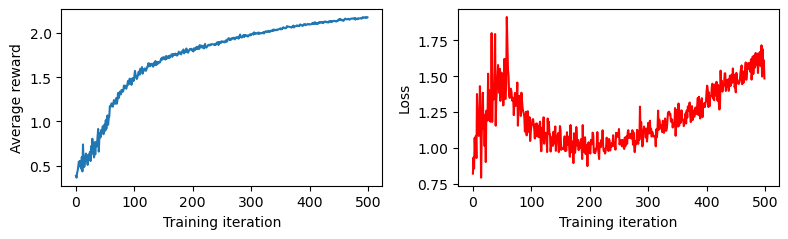

In [24]:
show_reward_loss(tr_rewards, rl_losses, filepath=plot_path)

In [25]:
df_history = write_history(tr_rewards, rl_losses, reconst_losses, entropy_losses,
                           gsk_list, jnk_list, qed_list, sa_list,
                           execution_times, losses_path)
print(df_history.shape)
print(df_history.head())

(500, 9)
     REWARD      LOSS  LOSS_RECONST  LOSS_ENTROPY  GSK3  JNK3  QED   SA  \
0  0.386910  0.819862      0.736761      0.083101   0.0   0.0  0.0  0.0   
1  0.365226  0.932036      0.853058      0.078978   0.0   0.0  0.0  0.0   
2  0.421572  0.855217      0.768549      0.086668   0.0   0.0  0.0  0.0   
3  0.447615  1.069008      0.987434      0.081574   0.0   0.0  0.0  0.0   
4  0.497781  0.960373      0.873086      0.087287   0.0   0.0  0.0  0.0   

    EXEC_TIME  
0   37.446692  
1   86.795418  
2  150.247192  
3  211.694731  
4  277.237173  


In [26]:
def save_smiles(filepath, smiles):
    with open(filepath, 'w') as fout:
        for smi in smiles:
            fout.write(f"{smi}\n")
    print(f"[INFO] {len(smiles)} SMILES were saved in {filepath}")

In [27]:
n_sampling = 30000

smi_after = SMILES_generate(ReBADD, n_sampling, gen_data)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [22:56<00:00, 21.80it/s]


In [28]:
save_smiles(os.path.join(dataconfigs.output_dir, "smi_after.csv"), smi_after)

[INFO] 30000 SMILES were saved in outputs_2_optimize_ReBADD/gsk3_jnk3_qed_sa/smi_after.csv
